C:\Users\adrip\AppData\Local\Temp\ipykernel_11276\1611332597.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(last_close_on_or_before(t0))
C:\Users\adrip\AppData\Local\Temp\ipykernel_11276\1611332597.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S1_real = float(last_close_on_or_before(t1))
C:\Users\adrip\AppData\Local\Temp\ipykernel_11276\1611332597.py:40: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mu = float(logret.mean())          # media diaria (log-ret)
C:\Users\adrip\AppData\Local\Temp\ipykernel_11276\1611332597.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sig

S0 (24-sep-2024): 564.44
S_real (24-sep-2025): 663.21
Sim P5: 551.86 | Mediana: 707.55 | P95: 908.18
VaR 1y (95% sobre retornos simulados): -2.23%
CVaR 1y (95%): -7.82%
Precio real cae en el percentil: P32.9
¿Real dentro de banda [P5, P95]? True
Error relativo de la mediana vs real: 6.69%


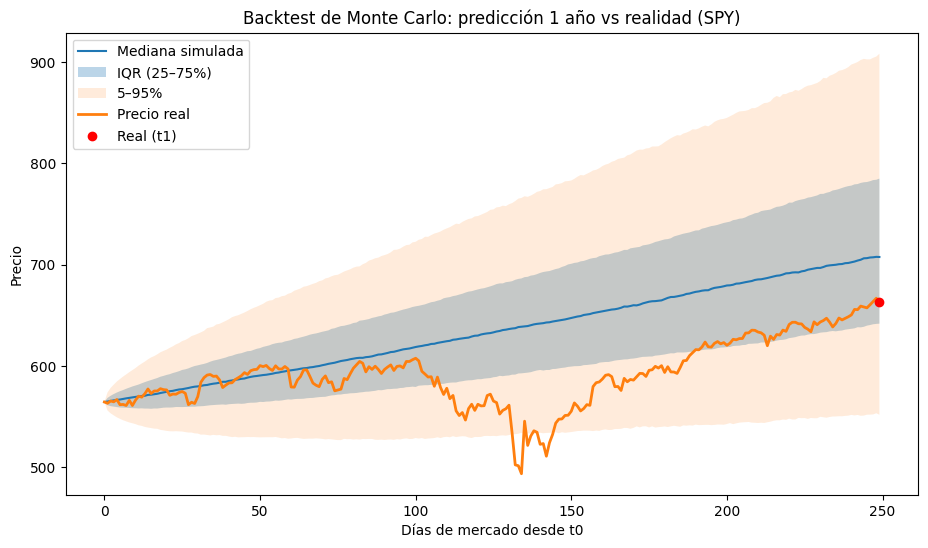

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Parámetros del experimento
# -----------------------------
ticker = "SPY"
t0 = "2024-09-24"  # fecha de arranque de la predicción
t1 = "2025-09-24"  # fecha de evaluación (real)
lookback_years = 2 # años para estimar mu y sigma
n_sims = 10000     # nº de trayectorias MC

# -----------------------------
# 2) Descargar datos (robusto)
# -----------------------------
start_download = (pd.to_datetime(t0) - pd.DateOffset(years=lookback_years+1)).strftime("%Y-%m-%d")
end_download   = t1

data = yf.download(ticker, start=start_download, end=end_download, auto_adjust=True, progress=False)
prices = data["Close"].dropna()

# Helpers para coger "la última cotización disponible" en o antes de la fecha dada
def last_close_on_or_before(date_str):
    return prices.loc[:pd.to_datetime(date_str)].iloc[-1]

# Precio inicial (S0) y precio real final (S1_real)
S0 = float(last_close_on_or_before(t0))
S1_real = float(last_close_on_or_before(t1))

# -----------------------------
# 3) Estimar μ y σ con ventana previa
#    (retornos log) en [t0 - lookback, t0]
# -----------------------------
train_start = (pd.to_datetime(t0) - pd.DateOffset(years=lookback_years))
train_prices = prices.loc[train_start:pd.to_datetime(t0)]
logret = np.log(train_prices / train_prices.shift(1)).dropna()

mu = float(logret.mean())          # media diaria (log-ret)
sigma = float(logret.std(ddof=1))  # vol diaria (log-ret)

# -----------------------------
# 4) Número de días de trading entre (t0, t1]
#    para alinear horizonte simulado con el real
# -----------------------------
horizon_index = prices.loc[pd.to_datetime(t0):pd.to_datetime(t1)].index
# quitamos el primer punto (t0) para simular solo días hacia delante
horizon_index = horizon_index[horizon_index > pd.to_datetime(t0)]
n_days = len(horizon_index)
if n_days == 0:
    # fallback: 252 días hábiles aprox
    n_days = 252

# -----------------------------
# 5) Simulación Monte Carlo (GBM en log-precios)
#    S_{t+1} = S_t * exp[(μ - 0.5σ²) + σ * Z_t]
#    (usamos dt=1 porque μ y σ son diarios)
# -----------------------------
rng = np.random.default_rng(42)
Z = rng.standard_normal(size=(n_days, n_sims))
drift = (mu - 0.5 * sigma**2)      # parte determinista por día
diff  = sigma * Z                  # shocks aleatorios por día

log_increments = drift + diff      # (n_days x n_sims)
log_paths = np.vstack([np.zeros(n_sims), log_increments]).cumsum(axis=0)
S_paths = S0 * np.exp(log_paths)   # (n_days+1) x n_sims

# -----------------------------
# 6) Distribución al final del año
# -----------------------------
terminal_prices = S_paths[-1, :]
terminal_returns = terminal_prices / S0 - 1

p5, p50, p95 = np.percentile(terminal_prices, [5, 50, 95])
vaR1y = np.percentile(terminal_returns, 5)
cvaR1y = terminal_returns[terminal_returns <= vaR1y].mean()

# Posición del precio real dentro de la distribución simulada
percentil_real = (terminal_prices <= S1_real).mean()  # e.g., 0.72 => P72
dentro_banda_5_95 = (S1_real >= p5) and (S1_real <= p95)

# Error relativo de la mediana simulada vs real
error_rel_median = (p50 - S1_real) / S1_real

print(f"S0 (24-sep-2024): {S0:.2f}")
print(f"S_real (24-sep-2025): {S1_real:.2f}")
print(f"Sim P5: {p5:.2f} | Mediana: {p50:.2f} | P95: {p95:.2f}")
print(f"VaR 1y (95% sobre retornos simulados): {vaR1y:.2%}")
print(f"CVaR 1y (95%): {cvaR1y:.2%}")
print(f"Precio real cae en el percentil: P{percentil_real*100:.1f}")
print(f"¿Real dentro de banda [P5, P95]? {dentro_banda_5_95}")
print(f"Error relativo de la mediana vs real: {error_rel_median:.2%}")

# -----------------------------
# 7) Gráficos (abanico + real)
# -----------------------------
# Percentiles diarios del abanico
p5_path  = np.percentile(S_paths, 5,  axis=1)
p25_path = np.percentile(S_paths, 25, axis=1)
p50_path = np.percentile(S_paths, 50, axis=1)
p75_path = np.percentile(S_paths, 75, axis=1)
p95_path = np.percentile(S_paths, 95, axis=1)

plt.figure(figsize=(11,6))
plt.plot(p50_path, label="Mediana simulada")
plt.fill_between(range(len(p25_path)), p25_path, p75_path, alpha=0.3, label="IQR (25–75%)")
plt.fill_between(range(len(p5_path)),  p5_path,  p95_path, alpha=0.15, label="5–95%")

# Superponemos la trayectoria real (si tenemos precios diarios reales del periodo)
real_segment = prices.loc[pd.to_datetime(t0):pd.to_datetime(t1)]
# Reindexamos la real al mismo eje de 0..n_days para superponer
if len(real_segment) > 1:
    # alineamos al largo de S_paths (n_days+1 puntos contando t0)
    plt.plot(range(len(real_segment)), real_segment.values, label="Precio real", linewidth=2)

# Marcamos el punto real final
plt.scatter([len(p50_path)-1], [S1_real], color="red", label="Real (t1)", zorder=5)

plt.title("Backtest de Monte Carlo: predicción 1 año vs realidad (SPY)")
plt.xlabel("Días de mercado desde t0")
plt.ylabel("Precio")
plt.legend()
plt.show()